# Galaxy Zoo 2 Galaxy classification project

by BRAUX Owen and CAMBIER Elliot in 2026

Ce notebook contient les recherches préliminaires, l'analyse des CSV Galaxy Zoo, les tests de l'API SDSS et n'est pas le résultat final ! 

In [1]:
import pandas as pd
import numpy as np
import os
import requests
from PIL import Image
from io import BytesIO
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
file_path = "../gz2_hart16.csv.gz" 

try:
    df = pd.read_csv(file_path, compression='gzip')
    print(f"Dimensions du dataset : {df.shape}")
    print(df.head())
    
    print("\n Colonnes dispo")
    print(df.columns.tolist()[:20]) 

except Exception as e:
    print(f" Erreur de lecture : {e}")

Dimensions du dataset : (239695, 231)
             dr7objid          ra        dec     rastring    decstring  \
0  587732591714893851  179.042984  60.522518  11:56:10.32  +60:31:21.1   
1  588009368545984617  135.084396  52.494240  09:00:20.26  +52:29:39.3   
2  587732484359913515  183.371979  50.741508  12:13:29.27  +50:44:29.4   
3  587741723357282317  186.251953  28.558598  12:25:00.47  +28:33:31.0   
4  587738410866966577  161.086395  14.084465  10:44:20.73  +14:05:04.1   

     sample gz2_class  total_classifications  total_votes  \
0  original      Sc+t                     45          342   
1  original      Sb+t                     42          332   
2  original        Ei                     36          125   
3  original      Sc+t                     28          218   
4  original        Er                     43          151   

   t01_smooth_or_features_a01_smooth_count  ...  \
0                                        0  ...   
1                                        1  ... 

In [3]:
import pandas as pd
import numpy as np

# MAPPING GALAXIES :
# main probabilities
col_smooth = 't01_smooth_or_features_a01_smooth_debiased'
col_features = 't01_smooth_or_features_a02_features_or_disk_debiased'
col_edgeon = 't02_edgeon_a04_yes_debiased' 
col_bar = 't03_bar_a06_bar_debiased'      
col_spiral = 't04_spiral_a08_spiral_debiased' 

# rounded a16 and a18
col_round = 't07_rounded_a16_completely_round_debiased'
col_cigar = 't07_rounded_a18_cigar_shaped_debiased'

# Winding
col_tight = 't10_arms_winding_a28_tight_debiased'
col_medium = 't10_arms_winding_a29_medium_debiased'
col_loose = 't10_arms_winding_a30_loose_debiased'

# Fusion
col_merger = 't08_odd_feature_a24_merger_debiased'

# CLASSIFICATION
def get_galaxy_class(row):
    try:     
        # CASE 1 : ROUND
        if row[col_smooth] > 0.8:
            if row[col_cigar] > 0.5:
                return 1 # E4-E7 
            elif row[col_round] > 0.5:
                return 0 # E0-E3 
            else:
                return 0 # DEFAULT E0-E3

        # CASE 2 : Merger
        if row[col_merger] > 0.6:
            return 9 

        # CASE 3 :S & S0
        if row[col_features] > 0.5 and row[col_edgeon] < 0.5:
            
            # S0
            if row[col_spiral] < 0.5:
                return 2 
                
            # Barre ?
            is_barred = (row[col_bar] > 0.5)
            
            # windings (Tight / Medium / Loose)
            winding_scores = [row[col_tight], row[col_medium], row[col_loose]]
            max_winding = np.argmax(winding_scores) 
            
            if is_barred:
                if max_winding == 0: return 6 # SBa
                if max_winding == 1: return 7 # SBb
                if max_winding == 2: return 8 # SBc
            else:
                if max_winding == 0: return 3 # Sa
                if max_winding == 1: return 4 # Sb
                if max_winding == 2: return 5 # Sc

        return -1 # Incertain
    
    except KeyError:
        return -1

# APPLCIATION
df['label'] = df.apply(get_galaxy_class, axis=1)

# cleaning
df_clean = df[df['label'] != -1].copy()

# Sampling
TARGET_PER_CLASS = 2000 
dfs_list = []

print("\nChargement des classes...")
class_names = {
    0: "E0-E3 (Ronde)", 1: "E4-E7 (Allongée)", 2: "S0 (Lenticulaire)",
    3: "Sa (Spirale Serrée)", 4: "Sb (Spirale Moyenne)", 5: "Sc (Spirale Lâche)",
    6: "SBa (Barrée Serrée)", 7: "SBb (Barrée Moyenne)", 8: "SBc (Barrée Lâche)",
    9: "Merger (Fusion)"
}

for label in range(10):
    df_class = df_clean[df_clean['label'] == label]
    count = len(df_class)
    
    print(f"   -> Classe {label} [{class_names[label]}] : {count} trouvées", end="")
    
    if count > TARGET_PER_CLASS:
        df_sampled = df_class.sample(n=TARGET_PER_CLASS, random_state=42)
        print(f" -> {TARGET_PER_CLASS} gardées (Cut)")
    else:
        df_sampled = df_class
        print(f" -> Tout gardé")
    
    dfs_list.append(df_sampled)

# Fusion finale
df_final = pd.concat(dfs_list).sample(frac=1, random_state=42).reset_index(drop=True)

# Sauvegarde
filename = "dataset_final_to_download.csv"
df_final.to_csv(filename, index=False)

print(f"Fichier {filename} généré.")
print(f"Total images à télécharger : {len(df_final)}")


Chargement des classes...
   -> Classe 0 [E0-E3 (Ronde)] : 49099 trouvées -> 2000 gardées (Cut)
   -> Classe 1 [E4-E7 (Allongée)] : 4530 trouvées -> 2000 gardées (Cut)
   -> Classe 2 [S0 (Lenticulaire)] : 22530 trouvées -> 2000 gardées (Cut)
   -> Classe 3 [Sa (Spirale Serrée)] : 35554 trouvées -> 2000 gardées (Cut)
   -> Classe 4 [Sb (Spirale Moyenne)] : 16790 trouvées -> 2000 gardées (Cut)
   -> Classe 5 [Sc (Spirale Lâche)] : 4691 trouvées -> 2000 gardées (Cut)
   -> Classe 6 [SBa (Barrée Serrée)] : 16533 trouvées -> 2000 gardées (Cut)
   -> Classe 7 [SBb (Barrée Moyenne)] : 15328 trouvées -> 2000 gardées (Cut)
   -> Classe 8 [SBc (Barrée Lâche)] : 4891 trouvées -> 2000 gardées (Cut)
   -> Classe 9 [Merger (Fusion)] : 3064 trouvées -> 2000 gardées (Cut)
Fichier dataset_final_to_download.csv généré.
Total images à télécharger : 20000


In [4]:
# CONFIG
CSV_FILE = "dataset_final_to_download.csv"
BASE_DIR = "dataset_images"
SDSS_URL = "http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
MAX_WORKERS = 15  # Number of concurrent downloads more than 15 is risky

# Mapping 
CLASS_NAMES = {
    0: "0_Elliptique_Ronde",
    1: "1_Elliptique_Allongee",
    2: "2_Lenticulaire",
    3: "3_Spirale_Serree",
    4: "4_Spirale_Moyenne",
    5: "5_Spirale_Lache",
    6: "6_Barree_Serree",
    7: "7_Barree_Moyenne",
    8: "8_Barree_Lache",
    9: "9_Merger_Irreguliere"
}

def download_single_image(row):
    try:
        label = row['label']
        objid = str(row['dr7objid'])
        ra = row['ra']
        dec = row['dec']
        
        folder = CLASS_NAMES[label]
        filepath = os.path.join(BASE_DIR, folder, f"{objid}.jpg")
        
        # skip if already exists
        if os.path.exists(filepath):
            return "EXIST"

        params = {
            'ra': ra, 'dec': dec, 'scale': 0.396, 
            'width': 128, 'height': 128, 'opt': ''
        }
        
        # slightly longer timeout since we share bandwidth
        response = requests.get(SDSS_URL, params=params, timeout=10)
        response.raise_for_status()
        
        img = Image.open(BytesIO(response.content))
        img.save(filepath)
        return "OK"
        
    except Exception as e:
        return "ERROR"

if __name__ == "__main__":
    df = pd.read_csv(CSV_FILE)
    
    # create folders
    for folder in CLASS_NAMES.values():
        os.makedirs(os.path.join(BASE_DIR, folder), exist_ok=True)
    
    print(f"Téléchargement : {len(df)} images avec {MAX_WORKERS} threads...")
    
    results = {"OK": 0, "EXIST": 0, "ERROR": 0}
    
    # use a Context Manager to manage threads cleanly
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # prepare the tasks
        futures = {executor.submit(download_single_image, row): index for index, row in df.iterrows()}
        
        # the progress bar follows completed futures
        for future in tqdm(as_completed(futures), total=len(df), unit="img"):
            status = future.result()
            results[status] += 1

    print("\n" + "="*30)
    print(f"Téléchargés : {results['OK']}")
    print(f"Déjà présents : {results['EXIST']}")
    print(f"Erreurs : {results['ERROR']}")
    print("="*30)

Téléchargement : 20000 images avec 15 threads...


100%|██████████| 20000/20000 [00:01<00:00, 16702.99img/s]


Téléchargés : 0
Déjà présents : 19995
Erreurs : 5


In [5]:
# PARAMS
BATCH_SIZE = 32      # Number of images per batch
IMG_SIZE = 128       # Input image size for the network
VAL_SPLIT = 0.2      # 20% for validation
SEED = 42            # For reproducibility

def get_data_loaders(data_dir):

    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        
        # data augmentation
        transforms.RandomRotation(180),     
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        
        transforms.ToTensor(), # image (0-255) -> tensor (0-1)
        
        # normalization
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    # validation
    val_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir)
    
    train_size = int((1 - VAL_SPLIT) * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], 
                                              generator=torch.Generator().manual_seed(SEED))
    
    # TECH NOTE from Owen and Elliot :
    # random_split keeps the parent's transforms by default.
    # we want train_transforms on train and val_transforms on val.
    # we chosed to load two datasets with different transforms and pick indices
    
    train_ds_raw = datasets.ImageFolder(root=data_dir, transform=train_transforms)
    val_ds_raw = datasets.ImageFolder(root=data_dir, transform=val_transforms)

    indices = torch.randperm(len(train_ds_raw), generator=torch.Generator().manual_seed(SEED)).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    train_subset = torch.utils.data.Subset(train_ds_raw, train_indices)
    val_subset = torch.utils.data.Subset(val_ds_raw, val_indices)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    print(f"-> Entrainement : {len(train_subset)} images")
    print(f"-> Validation : {len(val_subset)} images")
    print(f"-> Classes : {full_dataset.classes}")
    
    return train_loader, val_loader, full_dataset.classes

-> Entrainement : 15996 images
-> Validation : 3999 images
-> Classes : ['0_Elliptique_Ronde', '1_Elliptique_Allongee', '2_Lenticulaire', '3_Spirale_Serree', '4_Spirale_Moyenne', '5_Spirale_Lache', '6_Barree_Serree', '7_Barree_Moyenne', '8_Barree_Lache', '9_Merger_Irreguliere']


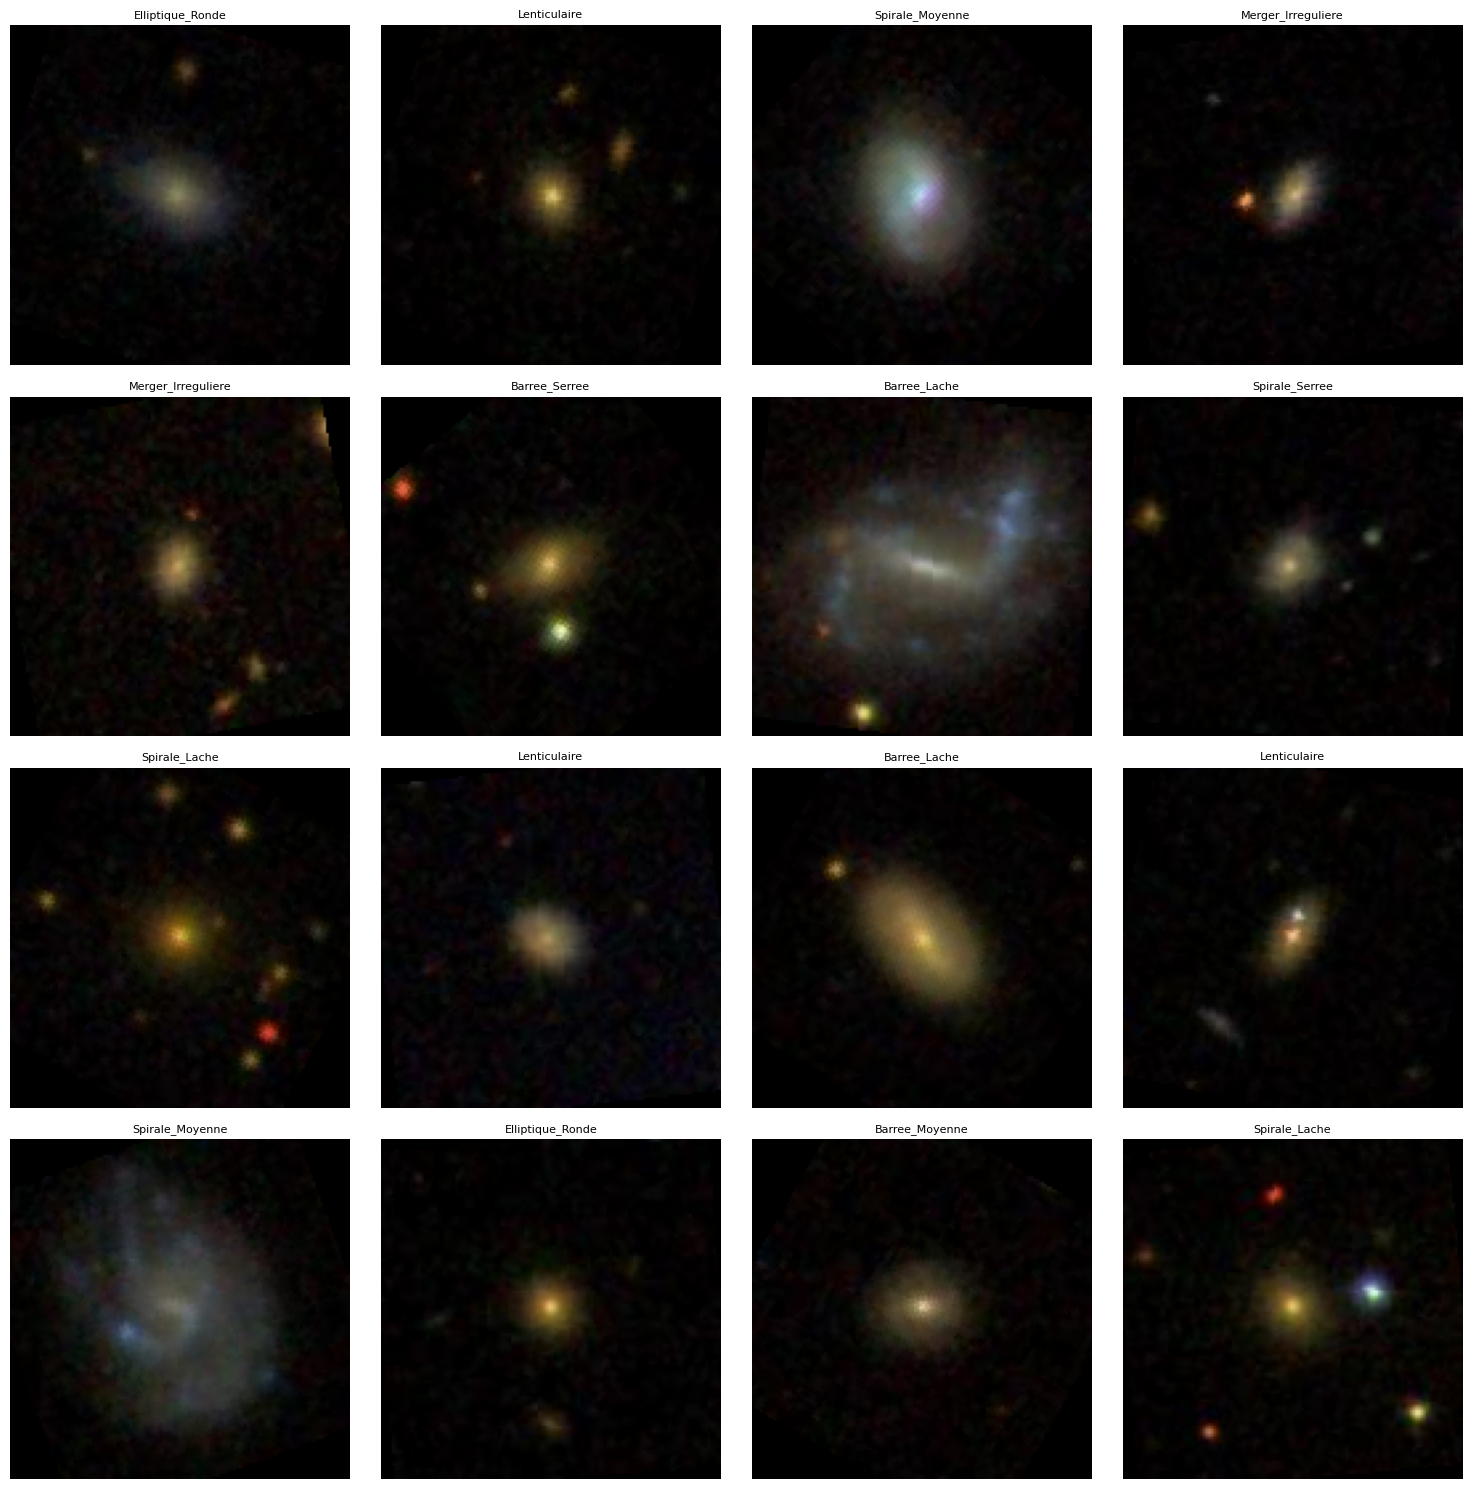

In [6]:
train_loader, val_loader, class_names = get_data_loaders("dataset_images")

def imshow(inp, title=None):
    """Function to denormalize and display a tensor image"""
    inp = inp.numpy().transpose((1, 2, 0)) # (C, H, W) -> (H, W, C)
    
    # undo ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=8)
    plt.axis('off')

inputs, classes = next(iter(train_loader))

plt.figure(figsize=(15, 15))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    label_idx = classes[i].item()
    label_name = class_names[label_idx]

    clean_name = label_name.split('_', 1)[1] 
    
    imshow(inputs[i], title=clean_name)

plt.tight_layout()
plt.show()

In [7]:
class GalaxyResNet(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(GalaxyResNet, self).__init__()
        
        # weights=DEFAUL' loads the most recent ImageNet weights
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GalaxyResNet(num_classes=10).to(device)

print(f"Load pour les {len(class_names)} classes.")

Load pour les 10 classes.


In [8]:
# CPU/GPU CONFIG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GalaxyResNet(num_classes=10).to(device)

# loss function 
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# TRAINING
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # training mode
                dataloader = train_loader
            else:
                model.eval()   # evaluation mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # batch loop
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # gradients to zero
                optimizer.zero_grad()

                # FORWARD
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # BACKWARD + OPTIMIZE
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # Checkpoint
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_galaxy_resnet.pth')
                print(f"--> New best! Model saved.")

        print()

    time_elapsed = time.time() - since
    print(f'Durée entrainement : {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleur acc : {best_acc:.4f}')

    # load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

# Run
trained_model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)

Epoch 1/2
----------
train Loss: 2.0227 Acc: 0.2659
val Loss: 2.1818 Acc: 0.2206
--> New best! Model saved.

Epoch 2/2
----------
train Loss: 1.8424 Acc: 0.3352
val Loss: 1.9067 Acc: 0.3388
--> New best! Model saved.

Durée entrainement : 5m 32s
Meilleur acc : 0.3388


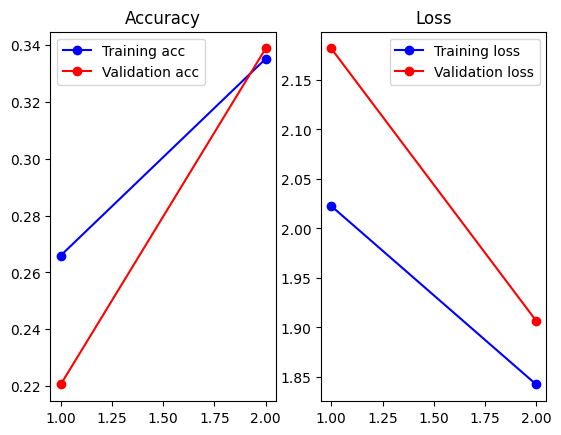

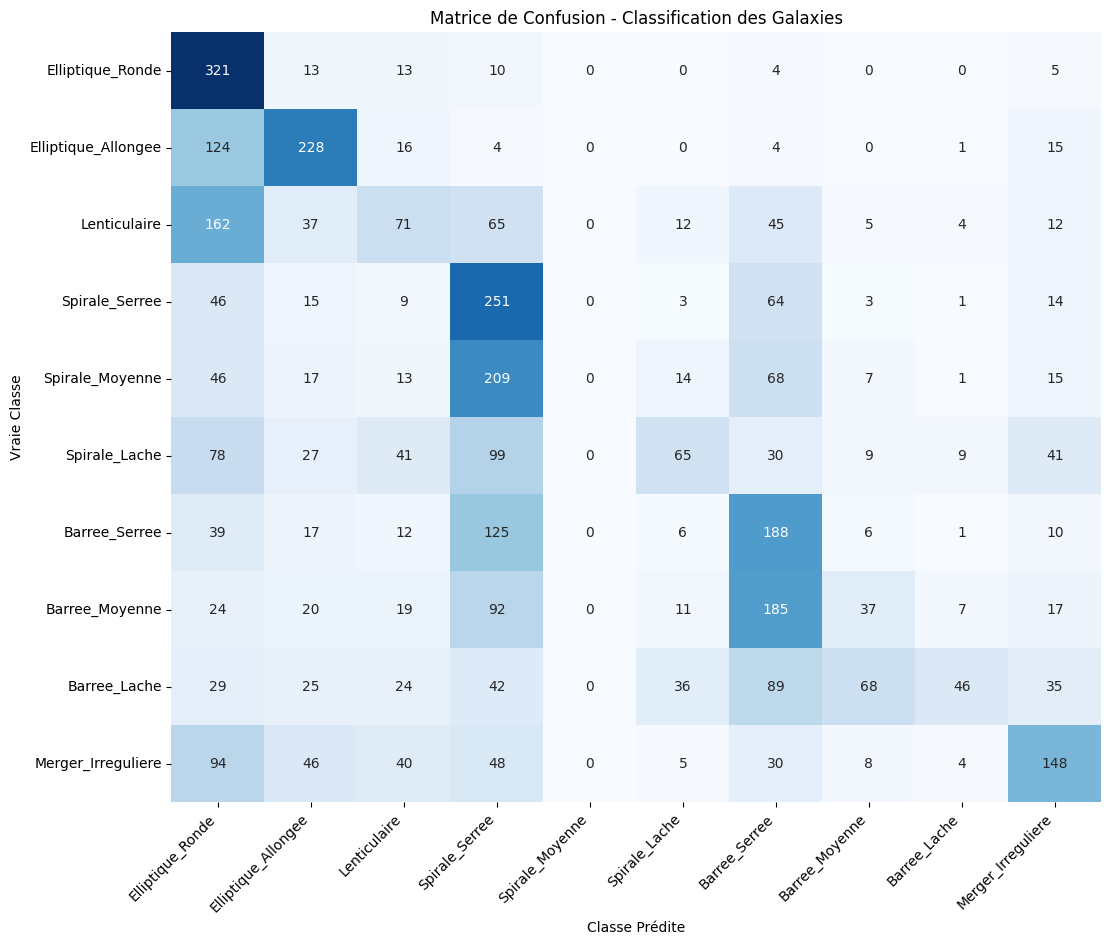

In [9]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure()

    # For Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    # For the loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Loss')
    plt.legend()

    plt.show()


def plot_confusion_matrix(model, val_loader, device, class_names):
    y_pred = []
    y_true = []
    model.eval() 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    clean_names = [name.split('_', 1)[1] if '_' in name else name for name in class_names]
    
    df_cm = pd.DataFrame(cm, index=clean_names, columns=clean_names)

    plt.figure(figsize=(12, 10))
    heatmap = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    plt.title('Matrice de Confusion - Classification des Galaxies')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

plot_training_history(history)
plot_confusion_matrix(model, val_loader, device, class_names)